In [37]:
import pandas as pd

# Import Data

In [38]:
csv_path = 'https://raw.githubusercontent.com/Mluthfialgifari/Tugas-Akhir-Skripsi/refs/heads/main/Data/Data%20TMA%20(Daily%202023-2024).csv'
df = pd.read_csv(csv_path)
df.head()

,Daily_Period,TMA_Daily
0,1/1/2023,43.750000
1,1/2/2023,36.666667
2,1/3/2023,32.916667
3,1/4/2023,32.173913
4,1/5/2023,30.000000


In [39]:
df

,Daily_Period,TMA_Daily
0,1/1/2023,43.750000
1,1/2/2023,36.666667
2,1/3/2023,32.916667
3,1/4/2023,32.173913
4,1/5/2023,30.000000
...,...,...
726,12/27/2024,20.000000
727,12/28/2024,15.000000
728,12/29/2024,3.125000
729,12/30/2024,11.666667


# Eksplorasi Data (Plot TS)

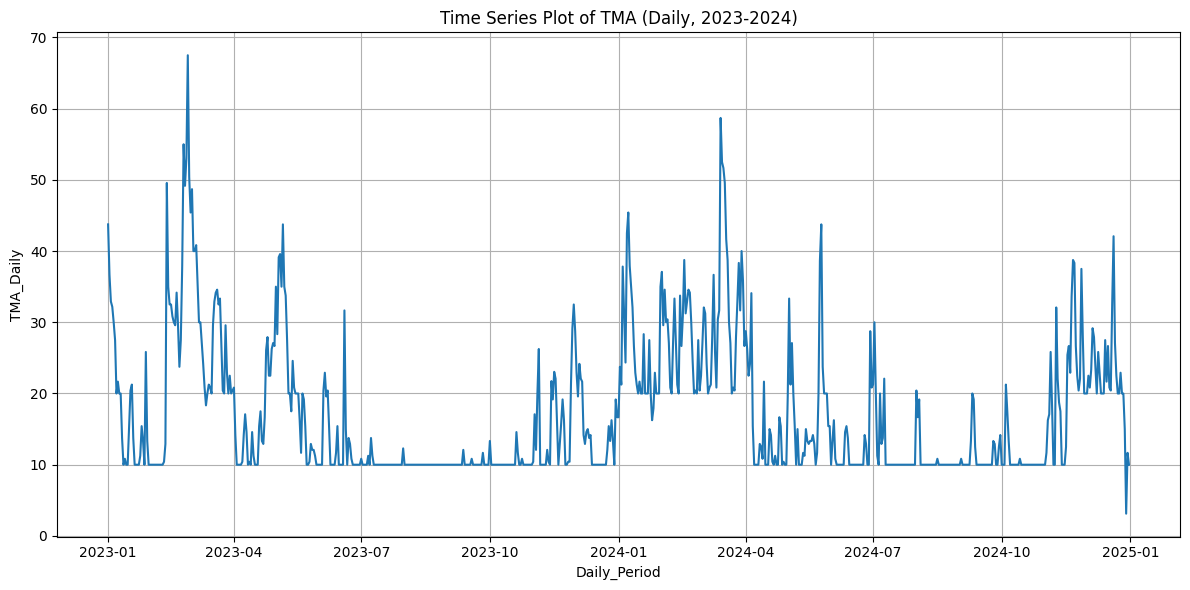

In [40]:
# Time Series Plot (Daily Data: Jan 2023 - Dec 2024)

import matplotlib.pyplot as plt

# Convert column to datetime objects
df['Daily_Period'] = pd.to_datetime(df['Daily_Period'])

# Create the time series plot
plt.figure(figsize=(12, 6))
plt.plot(df['Daily_Period'], df['TMA_Daily'])
plt.xlabel('Daily_Period')
plt.ylabel('TMA_Daily')
plt.title('Time Series Plot of TMA (Daily, 2023-2024)')
plt.grid(True)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Pembagian Data Latih dan Data Uji (Train & Test Data)

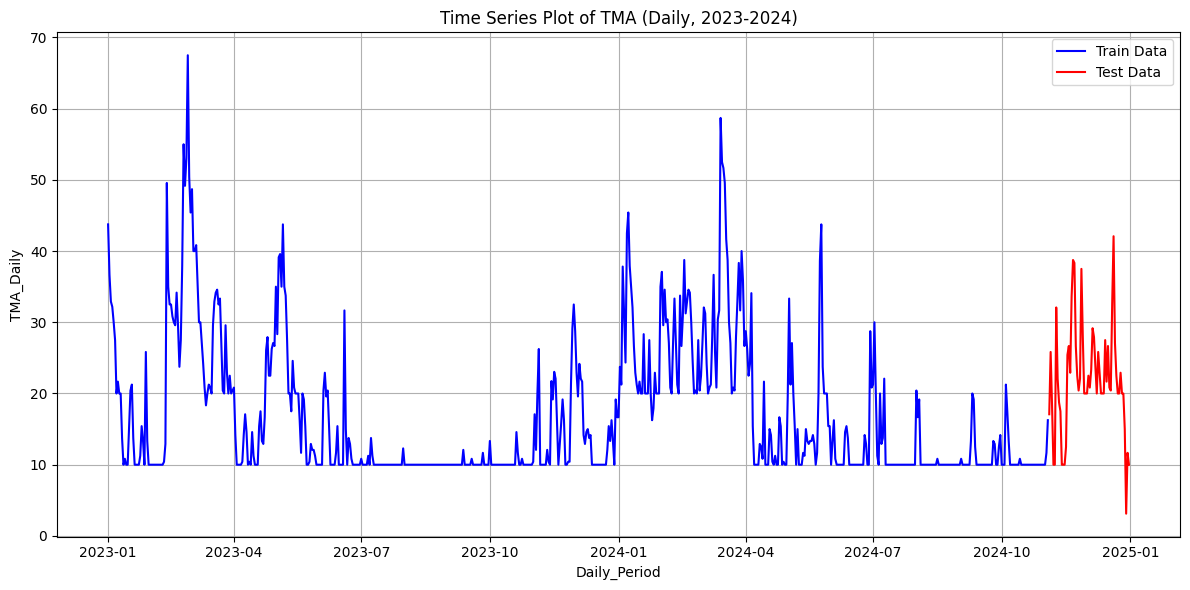

In [41]:
# Time Series Plot: Data Splitting (Train & Test Data)

import pandas as pd
import matplotlib.pyplot as plt

# Convert column to datetime objects
df['Daily_Period'] = pd.to_datetime(df['Daily_Period'])

# Split data into training and testing sets
train_data = df[(df['Daily_Period'] >= '1/1/2023') & (df['Daily_Period'] <= '11/3/2024')]
test_data = df[(df['Daily_Period'] >= '11/4/2024') & (df['Daily_Period'] <= '12/31/2024')]

# Create the time series plot with different colors for train and test data
plt.figure(figsize=(12, 6))
plt.plot(train_data['Daily_Period'], train_data['TMA_Daily'], label='Train Data', color='blue')
plt.plot(test_data['Daily_Period'], test_data['TMA_Daily'], label='Test Data', color='red')

plt.xlabel('Daily_Period')
plt.ylabel('TMA_Daily')
plt.title('Time Series Plot of TMA (Daily, 2023-2024)')
plt.grid(True)
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

In [42]:
len(train_data), len(test_data)

(673, 58)

# Cek Kestasioneran Data

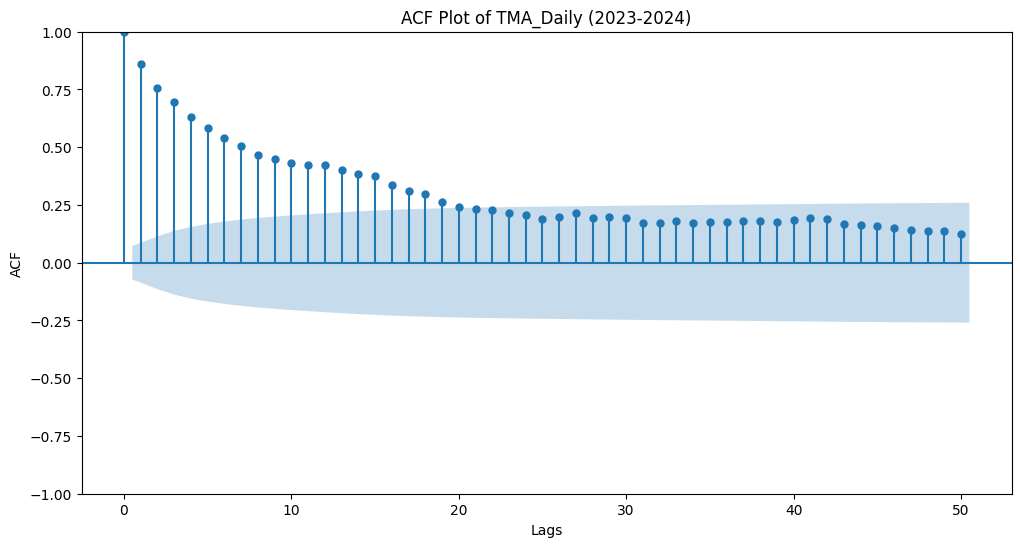

In [43]:
# Plot Autocorrelation Function (ACF)

from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(df['TMA_Daily'], lags=50, ax=ax) # Adjust 'lags' as needed
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.title('ACF Plot of TMA_Daily (2023-2024)')
plt.show()

**Interpretasi:**
Berdasarkan Plot ACF, dapat dilihat bahwa plot pada data tersebut cenderung *tails off* (slowly) dan tidak membentuk gelombang sinus, menandakan bahwa tersebut *tidak stasioner dalam rataan*

In [44]:
# Uji Augmented Dickey-Fuller (ADF)

from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test on the training data
result = adfuller(train_data['TMA_Daily'])

# Print the test results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Interpret the results
if result[1] <= 0.05:
    print("Strong evidence against the null hypothesis. Data is stationary.")
else:
    print("Weak evidence against the null hypothesis. Data is non-stationary.")

ADF Statistic: -5.378789
p-value: 0.000004
Strong evidence against the null hypothesis. Data is stationary.


**Interpretasi:**
Berdasarkan uji ADF, diperoleh *p-value* sebesar 0.000004, artinya lebih kecil dari taraf nyata 5% sehingga *tolak $H_0$* dan menunjukkan bahwa data tersebut *stasioner dalam rataan* (berbeda dengan plot ACF).

In [45]:
# Data Train ke dalam format DateTimeArray

import pandas as pd

# Convert the 'Daily_Period' column to DateTimeArray
train_data['Daily_Period'] = pd.to_datetime(train_data['Daily_Period']).dt.to_pydatetime()

# Train_data['Daily_Period'] is a DateTimeArray
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 673 entries, 0 to 672
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Daily_Period  673 non-null    datetime64[ns]
 1   TMA_Daily     673 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.8 KB
None


**Plot Box-Cox**

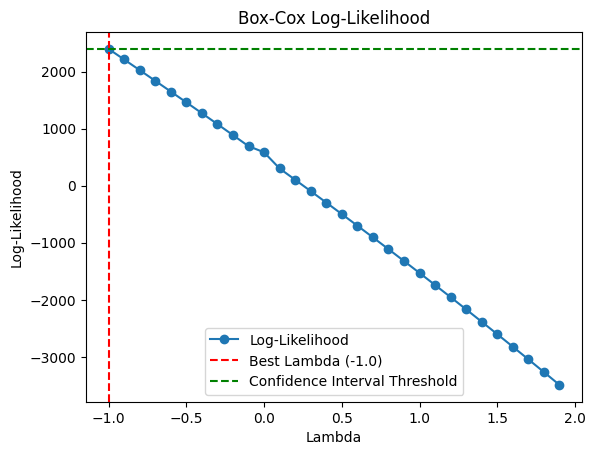

In [46]:
# Nilai Rounded Value Optimum (Lambda) & Confidence Interval 95%

import pandas as pd
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt

# Data
index = np.arange(0, len(train_data['TMA_Daily']))
lambda_values = np.arange(-1, 2, 0.1)  # Range of lambda

# Function to calculate log-likelihood
def boxcox_llf(df, lambdas):
    likelihoods = []
    n = len(df)
    for lmbda in lambdas:
        if lmbda == 0:
            transformed = np.log(df)
        else:
            transformed = (df**lmbda - 1) / lmbda
        log_likelihood = -n / 2 * np.log(np.var(transformed, ddof=1))
        likelihoods.append(log_likelihood)
    return likelihoods

# Calculate log-likelihood for each lambda
likelihoods = boxcox_llf(train_data['TMA_Daily'], lambda_values)

# Best lambda
best_lambda = lambda_values[np.argmax(likelihoods)]
#print("Rounded Best Lambda:", round(best_lambda, 2))

# Confidence Interval (95%)
ci_threshold = max(likelihoods) - 0.5 * chi2.ppf(0.95, df=1)
confidence_interval = lambda_values[np.array(likelihoods) > ci_threshold]
lower_bound = round(min(confidence_interval), 2)
upper_bound = round(max(confidence_interval), 2)
#print("Confidence Interval for Lambda:", (lower_bound, upper_bound))

# Plot Box-Cox
plt.plot(lambda_values, likelihoods, marker='o', label="Log-Likelihood")
plt.axvline(x=best_lambda, color='red', linestyle='--', label=f"Best Lambda ({round(best_lambda, 2)})")
plt.axhline(y=ci_threshold, color='green', linestyle='--', label="Confidence Interval Threshold")
plt.xlabel("Lambda")
plt.ylabel("Log-Likelihood")
plt.title("Box-Cox Log-Likelihood")
plt.legend()
plt.show()

In [47]:
lambda_values

array([-1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
       -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
       -2.00000000e-01, -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
        2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
        6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01,
        1.00000000e+00,  1.10000000e+00,  1.20000000e+00,  1.30000000e+00,
        1.40000000e+00,  1.50000000e+00,  1.60000000e+00,  1.70000000e+00,
        1.80000000e+00,  1.90000000e+00])

In [48]:
# Lower Bound and Upper Bound of Lambda values

lower_bound = min(lambda_values)
upper_bound = max(lambda_values)

print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)

# Rounded Value Optimum & Confidence Interval 95%

print("Rounded Best Lambda:", round(best_lambda, 2))
print("Confidence Interval for Lambda:", (lower_bound, upper_bound))

Lower Bound: -1.0
Upper Bound: 1.8999999999999995
Rounded Best Lambda: -1.0
Confidence Interval for Lambda: (-1.0, 1.8999999999999995)


**Interpretasi:**
Berdasarkan Plot Box-Cox, diperoleh nilai *rounded value* optimum sebesar **-1.0** dan pada selang kepercayaan 95% nilai memiliki batas bawah **-1.0** dan batas atas **1.8999999999999995**. Selang tersebut memuat nilai satu, sehingga dapat dikatakan bahwa data stasioner dalam ragam.

**Penanganan Ketidakstasioneran Data**

In [49]:
# Differencing (d=1) on training data
train_data['TMA_Daily_Diff'] = train_data['TMA_Daily'].diff(periods=1)
train_data = train_data.dropna()  # Drop the first row with NaN after differencing

# Augmented Dickey-Fuller Test after differencing
result_diff = adfuller(train_data['TMA_Daily_Diff'])
print('p-value after Differencing: %f' % result_diff[1])

if result_diff[1] <= 0.05:
    print("Strong evidence against the null hypothesis. Differenced data is stationary.")
else:
    print("Weak evidence against the null hypothesis. Differenced data is non-stationary.")

p-value after Differencing: 0.000000
Strong evidence against the null hypothesis. Differenced data is stationary.


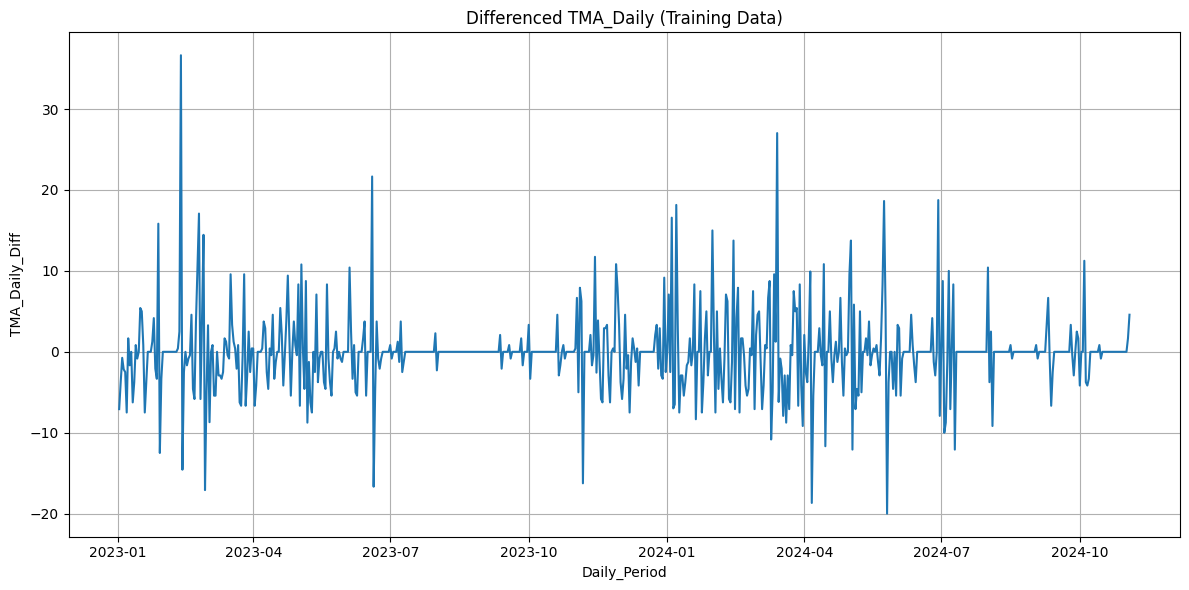

In [50]:
# Plot Difference (Differencing = 1)

# Plot the differenced training data
plt.figure(figsize=(12, 6))
plt.plot(train_data['Daily_Period'], train_data['TMA_Daily_Diff'])
plt.xlabel('Daily_Period')
plt.ylabel('TMA_Daily_Diff')
plt.title('Differenced TMA_Daily (Training Data)')
plt.grid(True)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Cek Kestasioneran Data (Kembali)**

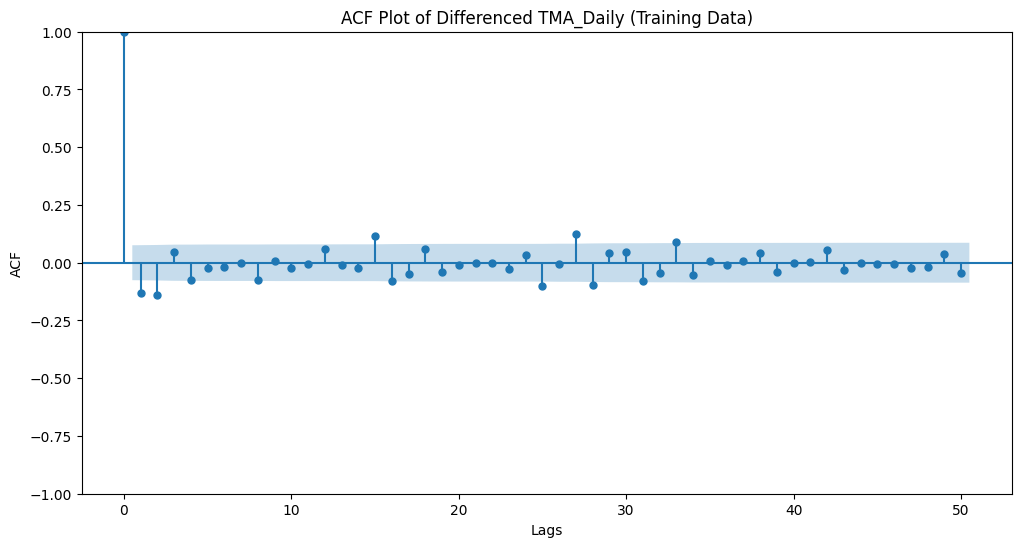

In [51]:
# ACF plot after differencing
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(train_data['TMA_Daily_Diff'], lags=50, ax=ax)
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.title('ACF Plot of Differenced TMA_Daily (Training Data)')
plt.show()

**Interpretasi:**
Berdasarkan plot ACF kembali, dapat dilihat bahwa plot ACF pada data tersebut cenderung *tails off* dan sudah membentuk gelombang sinus, menandakan bahwa data tersebut sudah *stasioner dalam rataan*

In [52]:
# Uji Augmented Dickey-Fuller (ADF) Kembali

# ADF Test using train data after differencing
result_diff = adfuller(train_data['TMA_Daily_Diff'])
print('p-value after Differencing: %f' % result_diff[1])

if result_diff[1] <= 0.05:
    print("Strong evidence against the null hypothesis. Differenced data is stationary.")
else:
    print("Weak evidence against the null hypothesis. Differenced data is non-stationary.")

p-value after Differencing: 0.000000
Strong evidence against the null hypothesis. Differenced data is stationary.


**Interpretasi:**
Berdasarkan uji ADF kembali, diperoleh *p-value* sebesar 0.000000, yang artinya lebih kecil dari taraf nyata 5% sehingga *tolak $H_0$* dan menunjukkan bahwa data sudah *stasioner dalam rataan* (sesuai plot ACF kembali)

**Identifikasi Model**

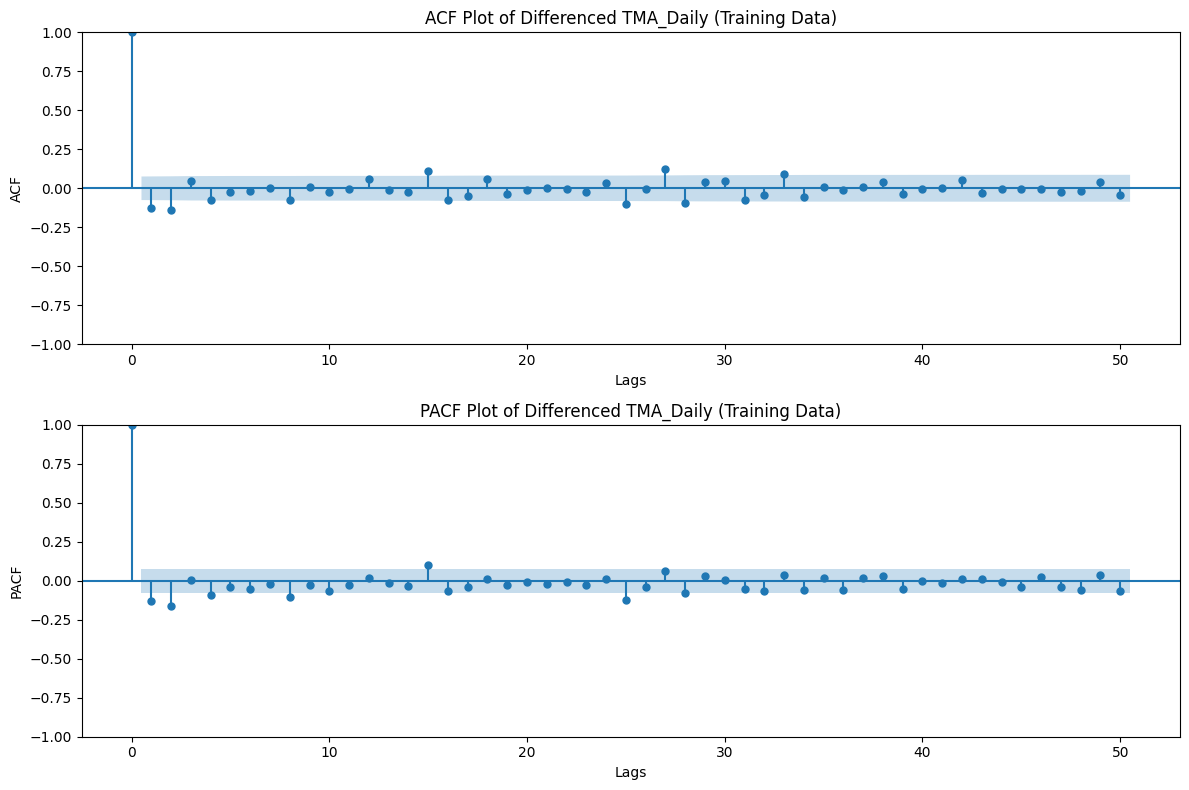

In [53]:
# Perbandingan Plot ACF dan PACF

from statsmodels.graphics.tsaplots import plot_pacf

# Plot ACF and PACF in one figure
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot
plot_acf(train_data['TMA_Daily_Diff'], lags=50, ax=axes[0])
axes[0].set_xlabel('Lags')
axes[0].set_ylabel('ACF')
axes[0].set_title('ACF Plot of Differenced TMA_Daily (Training Data)')

# PACF plot
plot_pacf(train_data['TMA_Daily_Diff'], lags=50, ax=axes[1])
axes[1].set_xlabel('Lags')
axes[1].set_ylabel('PACF')
axes[1].set_title('PACF Plot of Differenced TMA_Daily (Training Data)')

plt.tight_layout()
plt.show()

**Interpretasi:**
Berdasarkan plot tersebut, terlihat bahwa plot ACF cenderung *cuts off* pada lag ke 2, sehingga jika plot ACF dianggap *tails off*,  maka model tentatifnya adalah ARIMA(0,1,2). *ACF: MA(q)

**Interpretasi:**
Berdasarkan plot tersebut, terlihat bahwa plot PACF cenderung *cuts off* pada lag ke 2, sehingga jika plot PACF dianggap *tails off*, maka model tentatifnya adalah ARIMA(2,1,0). *PACF: AR(p)



**Pendugaan Parameter**

In [54]:
## ARIMA(0,1,2)

from statsmodels.tsa.arima.model import ARIMA
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Fit the ARIMA(0,1,2) model
model1 = ARIMA(train_data['TMA_Daily'], order=(0, 1, 2))
model1_fit = model1.fit()

# Print the model summary
print(model1_fit.summary())

# Access specific parameters (example: coefficients)
print("\nCoefficients:")
model1_fit.params

                               SARIMAX Results                                
Dep. Variable:              TMA_Daily   No. Observations:                  672
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1990.461
Date:                Wed, 22 Jan 2025   AIC                           3986.921
Time:                        14:22:30   BIC                           4000.447
Sample:                             0   HQIC                          3992.160
                                - 672                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1589      0.027     -5.837      0.000      -0.212      -0.106
ma.L2         -0.1815      0.033     -5.434      0.000      -0.247      -0.116
sigma2        22.0824      0.490     45.039      0.0

,0
ma.L1,-0.158866
ma.L2,-0.181521
sigma2,22.082407


**Interpretasi:**
Diperoleh nilai AIC sebesar 3964.511 dan koefisien model *signifikan*.

In [55]:
## ARIMA(2,1,0)

from statsmodels.tsa.arima.model import ARIMA
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Fit the ARIMA(2,1,0) model
model2 = ARIMA(train_data['TMA_Daily'], order=(2, 1, 0))
model2_fit = model2.fit()

# Print the model summary
print(model2_fit.summary())

# Access specific parameters (example: coefficients)
print("\nCoefficients:")
model2_fit.params

                               SARIMAX Results                                
Dep. Variable:              TMA_Daily   No. Observations:                  672
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1992.360
Date:                Wed, 22 Jan 2025   AIC                           3990.719
Time:                        14:22:30   BIC                           4004.245
Sample:                             0   HQIC                          3995.958
                                - 672                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1524      0.026     -5.807      0.000      -0.204      -0.101
ar.L2         -0.1620      0.032     -5.054      0.000      -0.225      -0.099
sigma2        22.2088      0.496     44.798      0.0

,0
ar.L1,-0.152446
ar.L2,-0.161958
sigma2,22.208762


**Interpretasi:**
Diperoleh nilai AIC sebesar 3968.902 dan koefisien model *signifikan*.

In [56]:
## ARIMA(2,1,2)

from statsmodels.tsa.arima.model import ARIMA
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Fit the ARIMA(2,1,2) model
model3 = ARIMA(train_data['TMA_Daily'], order=(2, 1, 2))
model3_fit = model3.fit()

# Print the model summary
print(model3_fit.summary())

# Access specific parameters (example: coefficients)
print("\nCoefficients:")
model3_fit.params

                               SARIMAX Results                                
Dep. Variable:              TMA_Daily   No. Observations:                  672
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1981.408
Date:                Wed, 22 Jan 2025   AIC                           3972.815
Time:                        14:22:30   BIC                           3995.359
Sample:                             0   HQIC                          3981.547
                                - 672                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1164      0.051     -2.279      0.023      -0.217      -0.016
ar.L2          0.7209      0.055     13.005      0.000       0.612       0.830
ma.L1         -0.0120      0.040     -0.297      0.7

,0
ar.L1,-0.116405
ar.L2,0.720877
ma.L1,-0.012018
ma.L2,-0.911526
sigma2,21.473590


**Interpretasi:**
Diperoleh nilai AIC sebesar 3949.401 dan koefisien model *signifikan*.

In [57]:
!pip install pmdarima

In [58]:
# Model Auto ARIMA

from pmdarima import auto_arima

# Fit auto_arima
stepwise_fit = auto_arima(train_data['TMA_Daily'], start_p=0, start_q=0,
                           max_p=2, max_q=2, m=1, #diff = 1
                           start_P=0, seasonal=False,
                           d=1, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4018.152, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4008.528, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4003.543, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4016.179, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3976.347, Time=1.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3994.498, Time=0.64 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3990.388, Time=0.61 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3988.857, Time=0.43 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3992.669, Time=0.88 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3974.542, Time=3.46 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3972.815, Time=2.73 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3988.443, Time=1.53 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3992.544, Time=1.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3974.637, Time=0.99 sec

Best model:  ARIMA(2,1,2)(0,0,0)

**Interpretasi:**
Diperoleh nilai AIC sebesar 3949.401 dan koefisien model *signifikan*.


In [59]:
# Rekapitulasi Nilai AIC Setiap Model

print(f"AIC for model1: {model1_fit.aic}") # ARIMA(0,1,2)
print(f"AIC for model2: {model2_fit.aic}") # ARIMA(2,1,0)
print(f"AIC for model3: {model3_fit.aic}") # ARIMA(2,1,2)
print(f"AIC for stepwise_fit: {stepwise_fit.aic()}") # ARIMA(2,1,2)

AIC for model1: 3986.9210119795457
AIC for model2: 3990.719019376249
AIC for model3: 3972.8152731869964
AIC for stepwise_fit: 3972.8152731869964


In [60]:
# Rekapitulasi Signifikansi Koefisien Model (Parameter)

# Access p-values for model1
p_values_model1 = model1_fit.pvalues
print("P-values for Model 1:")
for index, value in p_values_model1.items():
  if value < 0.05:
    print(f"{index}: {value} (significant)")
  else:
    print(f"{index}: {value} (not significant)")

# Access p-values for model2
p_values_model2 = model2_fit.pvalues
print("\nP-values for Model 2:")
for index, value in p_values_model2.items():
  if value < 0.05:
    print(f"{index}: {value} (significant)")
  else:
    print(f"{index}: {value} (not significant)")

# Access p-values for model3
p_values_model3 = model3_fit.pvalues
print("\nP-values for Model 3:")
for index, value in p_values_model3.items():
  if value < 0.05:
    print(f"{index}: {value} (significant)")
  else:
    print(f"{index}: {value} (not significant)")

print("\nP-values for Stepwise Fit (requires further extraction):")
print(stepwise_fit.summary())

P-values for Model 1:
ma.L1: 5.308918565268181e-09 (significant)
ma.L2: 5.497847608364785e-08 (significant)
sigma2: 0.0 (significant)

P-values for Model 2:
ar.L1: 6.351845653528e-09 (significant)
ar.L2: 4.3298121298078713e-07 (significant)
sigma2: 0.0 (significant)

P-values for Model 3:
ar.L1: 0.02267444705579184 (significant)
ar.L2: 1.1400826774670749e-38 (significant)
ma.L1: 0.7661802013621486 (not significant)
ma.L2: 1.502332680804319e-100 (significant)
sigma2: 0.0 (significant)

P-values for Stepwise Fit (requires further extraction):
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1981.408
Date:                Wed, 22 Jan 2025   AIC                           3972.815
Time:                        14:22:47   BIC                           3995.359
Sample:                             0   HQIC              

**Interpretasi:**
Berdasarkan summary model, jika diperoleh hasil nilai P>|Z| lebih kecil dari taraf nyata 5%, maka koefisien model (parameter) tersebut dinyatakan signifikan.

# Perbandingan Model Terbaik

In [61]:
# Perbandingan Hasil Akhir Model

import pandas as pd

data = {
    'Model': ['ARIMA(0,1,2)', 'ARIMA(2,1,0)', 'ARIMA(2,1,2)', 'Auto-ARIMA(2,1,2)'],
    'AIC': [model1_fit.aic, model2_fit.aic, model3_fit.aic, stepwise_fit.aic()],
    'Significance': ['Significant', 'Significant', 'Significant Portion', 'Significant Portion']
}

df_comparison = pd.DataFrame(data)
df_comparison

,Model,AIC,Significance
0,"ARIMA(0,1,2)",3986.921012,Significant
1,"ARIMA(2,1,0)",3990.719019,Significant
2,"ARIMA(2,1,2)",3972.815273,Significant Portion
3,"Auto-ARIMA(2,1,2)",3972.815273,Significant Portion


**Interpretasi:**
Penduga terbaik ialah penduga yang memiliki nilai AIC terkecil dan parameter (koefisien model) seluruhnya signifikan, yakni terdapat pada model ARIMA(0,1,2).


# Analisis Sisaan (Residuals Analysis)

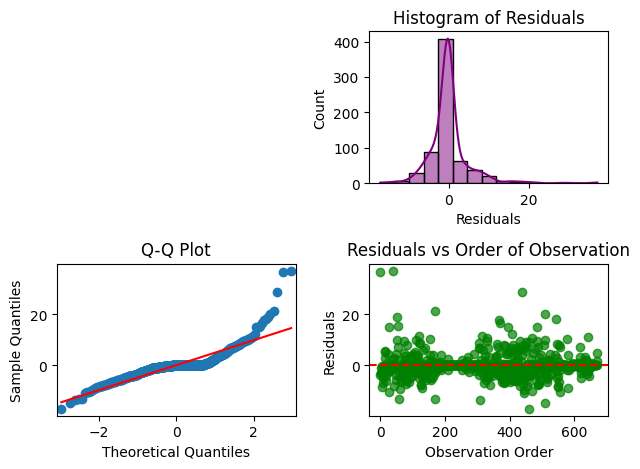

In [62]:
# Eksplorasi Sisaan

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# 1. Scatter plot nilai prediksi vs sisaan
#plt.figure(figsize=(10, 8))
#plt.subplot(2, 2, 1)
#plt.scatter(predicted, residuals, alpha=0.7, color='blue')
#plt.axhline(y=0, color='red', linestyle='--')
#plt.title("Predicted vs Residuals")
#plt.xlabel("Predicted Values")
#plt.ylabel("Residuals")

residuals = model1_fit.resid # Data Sisaan Best Model: ARIMA(0,1,2)

# 2. Histogram sisaan
plt.subplot(2, 2, 2)
sns.histplot(residuals, kde=True, bins=15, color='purple')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")

# 3. Q-Q plot
plt.subplot(2, 2, 3)
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title("Q-Q Plot")

# 4. Scatter plot sisaan vs urutan observasi
plt.subplot(2, 2, 4)
plt.scatter(range(len(residuals)), residuals, alpha=0.7, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Order of Observation")
plt.xlabel("Observation Order")
plt.ylabel("Residuals")

# Tampilkan semua plot
plt.tight_layout()
plt.show()

# Diagnostik Sisaan: Uji Normalitas Sisaan (KS Test)

## Pengujian Hipotesis:
### $H_0$: Sisaan menyebar normal
### $H_1$: Sisaan tidak menyebar normal

In [63]:
# Uji Normalitas Sisaan menggunakan KS Test

from scipy.stats import kstest

# as shown in the provided code.

# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value = kstest(residuals, 'norm')

print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

alpha = 0.05  # Significance level

if p_value > alpha:
    print("The residuals are normally distributed (fail to reject the null hypothesis)")
else:
    print("The residuals are not normally distributed (reject the null hypothesis)")

KS Statistic: 0.2306547619051006
P-value: 6.492800453493566e-32
The residuals are not normally distributed (reject the null hypothesis)


**Interpretasi:**
Berdasarkan uji normalitas menggunakan Kolmogorov-Smirnov Test, diperoleh *p-value* sebesar 6.492800453493566e-32 yang kurang dari taraf nyata 5% sehingga *tolak $H_0$*. Menunjukkan bahwa sisaan tidak menyebar normal (sesuai QQ Plot).

# Diagnostik Sisaan: Uji Kebebasan Sisaan (Ljung-Box Test)

## Pengujian Hipotesis:
### $H_0$: Sisaan saling bebas (tidak ada autokorelasi)
### $H_1$: Sisaan tidak saling bebas (ada autokorelasi)

In [64]:
# Uji Kebebasan Sisaan (Cek Autokorelasi)

from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform Ljung-Box test
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True) # You can adjust the lags
print(lb_test)

alpha = 0.05  # Significance level

if lb_test['lb_pvalue'][10] > alpha:
    print("The residuals are independent (fail to reject the null hypothesis)")
else:
    print("The residuals are not independent (reject the null hypothesis)")

      lb_stat  lb_pvalue
10  18.246832    0.05094
The residuals are independent (fail to reject the null hypothesis)


**Interpretasi:**
Berdasarkan uji kebebasan sisaan menggunakan Ljung-Box Test, diperoleh *p-value* sebesar 0.05094 yang lebih besar dari taraf nyata 5% sehingga *tak tolak $H_0$*. Menunjukkan bahwa sisaan saling bebas (tidak ada autokorelasi).

# Diagnostik Sisaan: Uji Homoskedastisitas Ragam Sisaan (Ljung-Box Test)

## Pengujian Hipotesis:
### $H_0$: Ragam sisaan homogen
### $H_1$: Ragam sisaan tidak homogen (heterogen)

In [65]:
# Homoskedastisitas Ragam Sisaan

import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox

# Uji Ljung-Box
lb_test = acorr_ljungbox(residuals, lags=[20], return_df=True)

# Hasil uji
print(lb_test)

# Interpretasi hasil
p_value = lb_test['lb_pvalue'].values[0]

alpha = 0.05  # Taraf nyata 5%
if p_value < alpha:
    print("Reject the null hypothesis: Ragam sisaan tidak homogen (heterogen)")
else:
    print("Fail to reject the null hypothesis: Ragam sisaan homogen")


      lb_stat  lb_pvalue
20  33.197002   0.032098
Reject the null hypothesis: Ragam sisaan tidak homogen (heterogen)


**Interpretasi:**
Berdasarkan uji ragam sisaan menggunakan Ljung-Box tersebut, diperoleh *p-value* sebesar *0.032098* yang lebih kecil dari taraf nyata 5% sehingga *tolak $H_0$* dan menunjukkan bahwa ragam sisaan tidak homogen (heterogen)


# Diagnostik Sisaan: Uji Nilai Tengah Sisaan (t-test)

## Pengujian Hipotesis:
### $H_0$: Nilai harapan sisaan sama dengan nol
### $H_1$: Nilai harapan sisaan tidak sama dengan nol

In [66]:
# Uji Nilai Harapan Sisaan = 0

import numpy as np
from scipy.stats import ttest_1samp

# Uji asumsi sisaan nilai harapan sama dengan nol
t_statistic, p_value = ttest_1samp(residuals, 0)

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

alpha = 0.05  # Significance level

if p_value > alpha:
    print("Nilai harapan sisaan sama dengan nol (gagal menolak hipotesis nol)")
else:
    print("Nilai harapan sisaan tidak sama dengan nol (tolak hipotesis nol)")

T-statistic: 0.02420856980243618
P-value: 0.9806934397733474
Nilai harapan sisaan sama dengan nol (gagal menolak hipotesis nol)


**Interpretasi:**
Berdasarkan uji nilai tengah sisaan menggunakan t-test, diperoleh *p-value* sebesar *0.9806934397733474* yang lebih besar dari taraf nyata 5% sehingga *tak tolak $H_0$* dan menunjukkan bahwa nilai harapan sisaan sama dengan nol.


In [67]:
# P-value Uji Asumsi Analisis Sisaan

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import numpy as np
from scipy.stats import chi2
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
from pmdarima import auto_arima
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import kstest
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import ttest_1samp

# Uji Normalitas Sisaan (KS Test)
ks_statistic, p_value_normality = kstest(residuals, 'norm')
print(f"P-value (Normality): {p_value_normality}")

# Uji Kebebasan Sisaan (Ljung-Box Test)
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
p_value_independence = lb_test['lb_pvalue'][10]
print(f"P-value (Independence): {p_value_independence}")

# Homoskedastisitas Ragam Sisaan (Ljung-Box Test)
lb_test = acorr_ljungbox(residuals, lags=[20], return_df=True)
p_value_homoscedasticity = lb_test['lb_pvalue'].values[0]
print(f"P-value (Homoscedasticity): {p_value_homoscedasticity}")

# Uji Nilai Harapan Sisaan Nol (t-test)
t_statistic, p_value_mean = ttest_1samp(residuals, 0)
print(f"P-value (Mean): {p_value_mean}")

P-value (Normality): 6.492800453493566e-32
P-value (Independence): 0.050939959696918884
P-value (Homoscedasticity): 0.03209840110121017
P-value (Mean): 0.9806934397733474


# Hasil Diagnostik Sisaan Model ARIMA(0,1,2)

In [68]:
import pandas as pd

data = {
    'Asumsi Sisaan': ['Normalitas', 'Autokorelasi', 'Homoskedastisitas', 'Nilai Tengah Sisaan Nol'],
    'Uji Formal': ['Kolmogorov-Smirnov Test', 'Ljung-Box Test', 'Ljung-Box Test', 't-test'],
    'P-value': [p_value_normality, p_value_independence, p_value_homoscedasticity, p_value_mean],
    'Kesimpulan': ['Sisaan tidak menyebar normal', 'Sisaan saling bebas', 'Ragam sisaan tidak homogen', 'Nilai harapan sisaan nol']
}

df_comparison = pd.DataFrame(data)
df_comparison

,Asumsi Sisaan,Uji Formal,P-value,Kesimpulan
0,Normalitas,Kolmogorov-Smirnov Test,6.492800e-32,Sisaan tidak menyebar normal
1,Autokorelasi,Ljung-Box Test,5.093996e-02,Sisaan saling bebas
2,Homoskedastisitas,Ljung-Box Test,3.209840e-02,Ragam sisaan tidak homogen
3,Nilai Tengah Sisaan Nol,t-test,9.806934e-01,Nilai harapan sisaan nol


# Pemodelan GARCH

In [69]:
!pip install arch

In [70]:
import numpy as np
import pandas as pd
from arch import arch_model
import matplotlib.pyplot as plt

## Splitting Data

Splitting data dilakukan dengan membagi data menjadi data latih sebanyak 914 amatan dan data uji sebanyak 60 amatan.

In [71]:
train_size = 673
test_size = 58

train_data = df.iloc[:-test_size]
test_data = df.iloc[-test_size:]

print("Jumlah data latih:", len(train_data))
print("Jumlah data uji:", len(test_data))

Jumlah data latih: 673
Jumlah data uji: 58


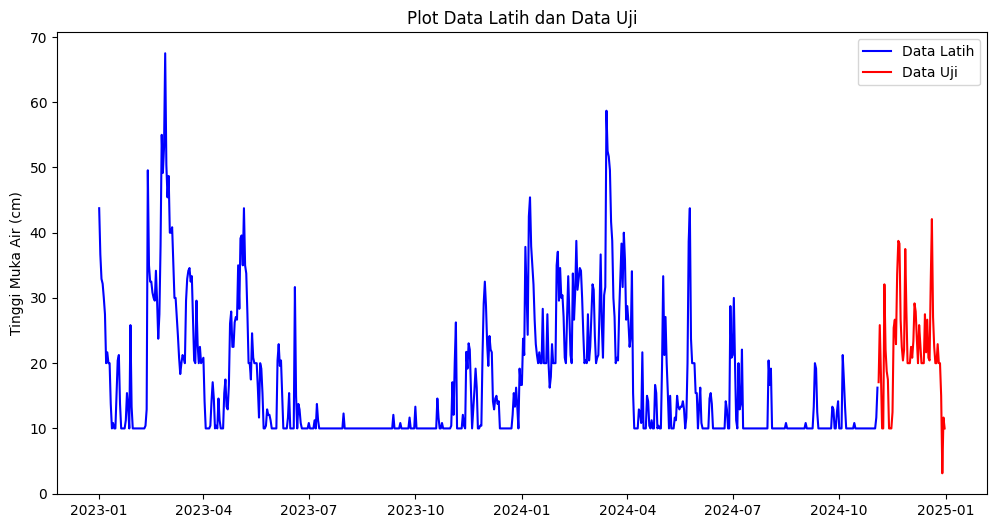

In [72]:
# Membuat plot data latih dan data uji
plt.figure(figsize=(12, 6))
plt.plot(train_data['Daily_Period'], train_data['TMA_Daily'], label='Data Latih', color='blue')
plt.plot(test_data['Daily_Period'], test_data['TMA_Daily'], label='Data Uji', color='red')
plt.title('Plot Data Latih dan Data Uji')
plt.ylabel('Tinggi Muka Air (cm)')
plt.legend()
plt.show()

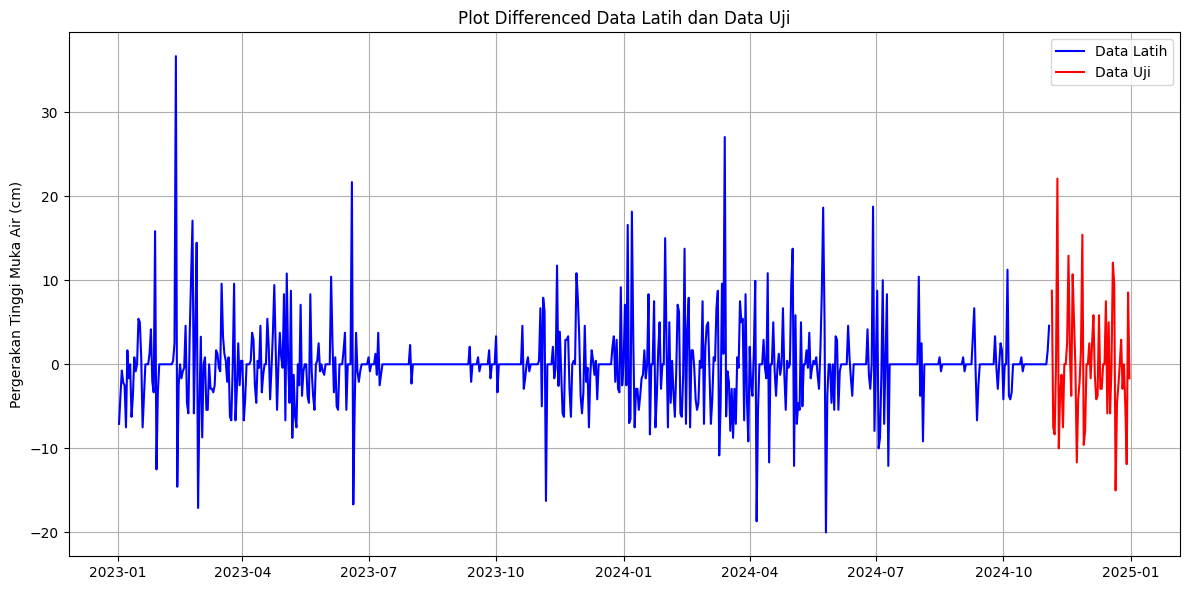

In [73]:
# Plot Differenced Data Latih dan Data Uji

# Differencing (d=1) on training data
train_data['TMA_Daily_Diff'] = train_data['TMA_Daily'].diff(periods=1)
train_data = train_data.dropna()

# Differencing (d=1) on testing data
test_data['TMA_Daily_Diff'] = test_data['TMA_Daily'].diff(periods=1)
test_data = test_data.dropna()

# Plot the differenced training and testing data
plt.figure(figsize=(12, 6))
plt.plot(train_data['Daily_Period'], train_data['TMA_Daily_Diff'], label='Data Latih', color='blue')
plt.plot(test_data['Daily_Period'], test_data['TMA_Daily_Diff'], label='Data Uji', color='red')
plt.ylabel('Pergerakan Tinggi Muka Air (cm)')
plt.title('Plot Differenced Data Latih dan Data Uji')
plt.grid(True)
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()
plt.show()

In [74]:
data_diff = pd.concat([train_data['TMA_Daily_Diff'], test_data['TMA_Daily_Diff']])

In [75]:
train_data_diff = data_diff.iloc[:-test_size]
test_data_diff = data_diff.iloc[-test_size:]

print(train_data_diff.head())
print(train_data_diff.shape)

print(test_data_diff.head())
print(test_data_diff.shape)

1   -7.083333
2   -3.750000
3   -0.742754
4   -2.173913
5   -2.500000
Name: TMA_Daily_Diff, dtype: float64
(671,)
672    4.583333
674    8.750000
675   -7.500000
676   -8.333333
677    0.000000
Name: TMA_Daily_Diff, dtype: float64
(58,)


In [76]:
!pip install arch

## Pendugaan Parameter

In [77]:
from arch import arch_model

# Specify the GARCH(1, 1) model
model_garch11_diff = arch_model(train_data['TMA_Daily_Diff'], vol='GARCH', mean = 'constant', p=1, q=1)

# Fit the model
result_garch11_diff = model_garch11_diff.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4107.311077329814
Iteration:      2,   Func. Count:     13,   Neg. LLF: 2014.4587635770997
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1932.3743214598626
Iteration:      4,   Func. Count:     25,   Neg. LLF: 1931.60472365928
Iteration:      5,   Func. Count:     31,   Neg. LLF: 12757.541152693742
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1933.7511858406006
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1917.3562448209964
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1914.9966357287885
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1915.2673804278093
Iteration:     10,   Func. Count:     61,   Neg. LLF: 1914.6439785270359
Iteration:     11,   Func. Count:     66,   Neg. LLF: 1914.6168817090822
Iteration:     12,   Func. Count:     71,   Neg. LLF: 1914.6144300795886
Iteration:     13,   Func. Count:     76,   Neg. LLF: 1914.6143901612909
Iteration:     14,   Func. Count:     81,   Neg. LLF: 

In [78]:
# Display model fitting summary
print(result_garch11_diff.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:         TMA_Daily_Diff   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1914.61
Distribution:                  Normal   AIC:                           3837.23
Method:            Maximum Likelihood   BIC:                           3855.27
                                        No. Observations:                  672
Date:                Wed, Jan 22 2025   Df Residuals:                      671
Time:                        14:22:59   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1393  9.640e-02      1.445      0.148 [-4.96

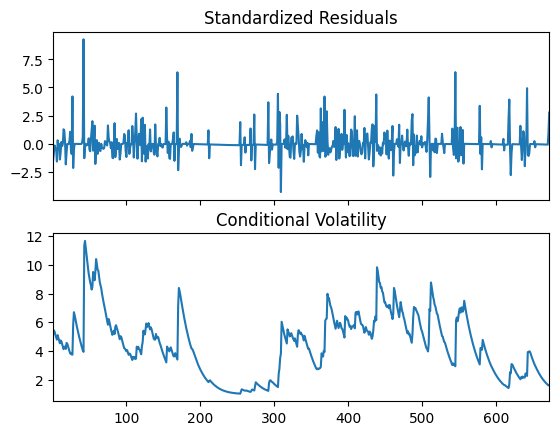

In [79]:
fig = result_garch11_diff.plot()

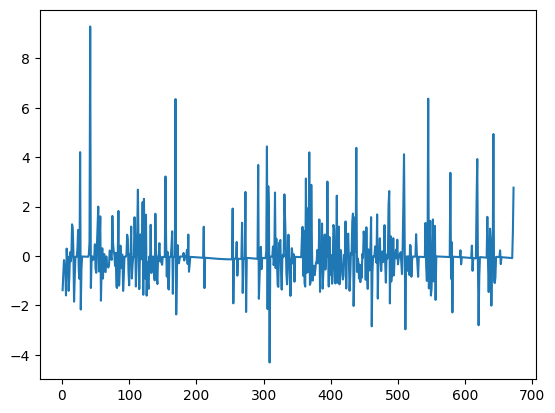

In [80]:
garch_stresidual = result_garch11_diff.resid / result_garch11_diff.conditional_volatility
plt.plot(garch_stresidual)

### Diagnostik Sisaan Model GARCH: Uji Normalitas Sisaan (KS Test)

#### Pengujian Hipotesis

##### $H_0$: Sisaan menyebar normal
##### $H_1$: Sisaan tidak menyebar normal

In [81]:
from scipy import stats
result_norm = stats.kstest(garch_stresidual, 'norm')
print(result_norm.pvalue)

1.2147439387388173e-37


**Interpretasi:**
Berdasarkan uji normalitas sisaan (KS Test), diperoleh *p-value* sebesar 1.2147439387388173e-37 yang kurang dari taraf nyata 5% sehingga *tolak $H_0$*. Menunjukkan bahwa sisaan tidak menyebar normal.

### Diagnostik Sisaan Model GARCH: Uji Kebebasan Sisaan (Ljung-Box Test)

#### Pengujian Hipotesis

##### $H_0$: Sisaan saling bebas
##### $H_1$: Sisaan tidak saling bebas

In [82]:
import statsmodels.api as sm
result_df = sm.stats.acorr_ljungbox(abs(garch_stresidual), lags=[10], return_df=True)
print(result_df)

      lb_stat     lb_pvalue
10  52.988187  7.483657e-08


**Interpretasi:**
Berdasarkan uji kebebasan sisaan (Ljung-Box Test), diperoleh *p-value* sebesar  7.483657e-08 yang kurang dari taraf nyata 5% sehingga *tolak $H_0$*. Menunjukkan bahwa sisaan tidak saling bebas (ada autokorelasi).

### Diagnostik Sisaan Model GARCH: Uji Homoskedastisitas Ragam Sisaan (ARCH-LM Test)

#### Pengujian Hipotesis

##### $H_0$: Ragam sisaan homogen
##### $H_1$: Ragam sisaan tidak homogen

In [83]:
# ARCH-LM Test for Homoscedasticity of Residuals
from statsmodels.stats.diagnostic import het_arch

arch_test = het_arch(garch_stresidual)
print(arch_test)

# Interpretation
p_value_arch = arch_test[1]  # Extract p-value
alpha = 0.05  # significance level

if p_value_arch < alpha:
    print("Reject the null hypothesis: Residual variance is not homogeneous (heterogeneous).")
else:
    print("Fail to reject the null hypothesis: Residual variance is homogeneous.")

(3.591322944440835, 0.9639061906606501, 0.3550911946188876, 0.9649165777703848)
Fail to reject the null hypothesis: Residual variance is homogeneous.


**Interpretasi:**
Berdasarkan uji homogenitas ragam sisaan (ARCH-LM Test), diperoleh *p-value* lebih besar dari taraf nyata 5% sehingga *tak tolak $H_0$* dan menunjukkan bahwa ragam sisaan homogen (tidak ada efek ARCH).

### Diagnostik Sisaan Model GARCH: Uji Nilai Harapan Sisaan Nol

#### Pengujian Hipotesis

##### $H_0$: Nilai harapan sisaan sama dengan nol
##### $H_1$: Nilai harapan sisaan tidak sama dengan nol

In [84]:
result_harapan = stats.ttest_1samp(garch_stresidual, 0)
print(result_harapan.pvalue)

0.8096881453685533


**Interpretasi:**
Berdasarkan uji nilai harapan sisaan nol (t-test), diperoleh *p-value* sebesar 0.8096881453685533 yang lebih besar dari taraf nyata 5%. Menunjukkan bahwa nilai tengah sisaan sama dengan 0.

### Data Sisaan Model GARCH

In [85]:
garch_stresidual.to_excel("garch_stresidual.xlsx", index=False)

## Prediksi

Pendugaan nilai amatan menggunakan model GARCH(1,1) dilakukan pada data latih dan uji untuk menghitung nilai keakuratan model.

In [86]:
np.random.seed(31)
epsilon_train = np.random.normal(0, 1, 672)

### Prediksi pada Data Latih (Train Data)

In [87]:
predicted_train = result_garch11_diff.conditional_volatility * epsilon_train - 0.0159
predicted_train

,cond_vol
1,-2.179482
2,-1.824654
3,0.415399
4,-4.049582
5,-1.093653
...,...
668,-1.282679
669,-0.099965
670,-1.785547
671,-2.043934


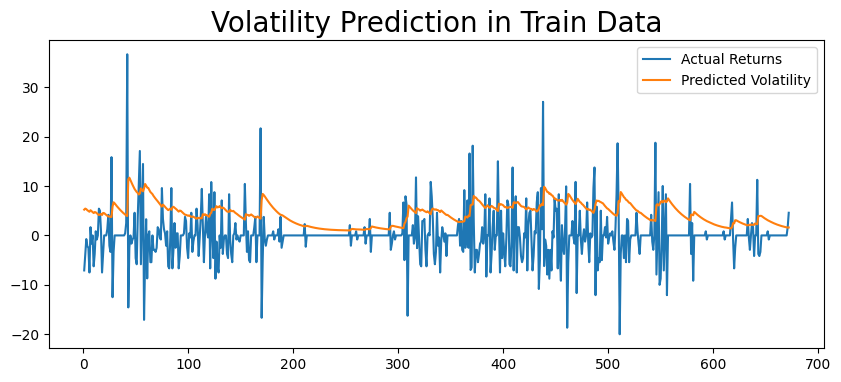

In [88]:
plt.figure(figsize=(10,4))
true, = plt.plot(train_data['TMA_Daily_Diff'])
preds, = plt.plot(result_garch11_diff.conditional_volatility)
plt.title('Volatility Prediction in Train Data', fontsize=20)
plt.legend(['Actual Returns', 'Predicted Volatility'], fontsize=10)

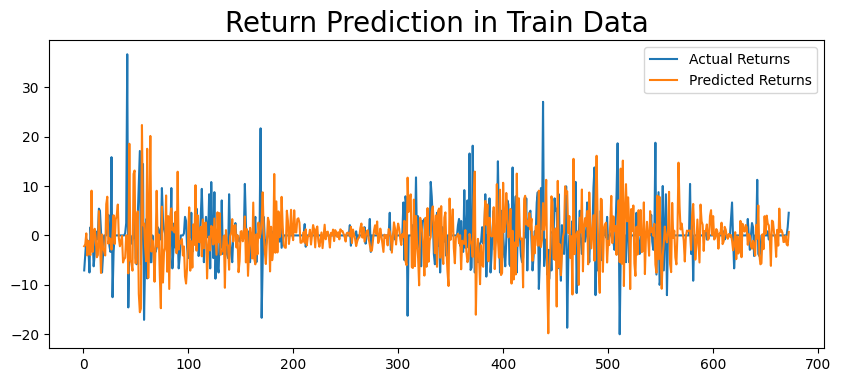

In [89]:
plt.figure(figsize=(10,4))
true, = plt.plot(train_data['TMA_Daily_Diff'])
preds, = plt.plot(predicted_train)
plt.title('Return Prediction in Train Data', fontsize=20)
plt.legend(['Actual Returns', 'Predicted Returns'], fontsize=10)

In [90]:
predicted_train.to_excel("predicted_train.xlsx", index=False)

## Prediksi pada Data Uji (Test Data)

In [91]:
data_diff = pd.concat([train_data['TMA_Daily_Diff'], test_data['TMA_Daily_Diff']])

In [92]:
condvar_test = []

for i in range(test_size):
    train = data_diff[:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    condvar_test.append(np.sqrt(pred.variance.values[-1,:][0]))

In [93]:
condvar_test

[1.557976551699388,
 2.034194449184464,
 3.228485199903128,
 3.848446576446471,
 4.479114053524794,
 4.283814662355675,
 7.987399688303762,
 8.235602935671565,
 7.903012184539776,
 7.528636775992465,
 7.548067727633801,
 7.183982588832204,
 6.841046659984761,
 6.557480931895041,
 7.388188585309353,
 7.043924853463012,
 6.816779606006881,
 7.265101474077987,
 7.088486312940635,
 6.755317122018709,
 7.3945053860974275,
 7.167801017255046,
 6.863309138691021,
 6.557188298890017,
 7.817844402940575,
 8.027391770642662,
 8.038685360453062,
 7.656181641909277,
 7.29403311559246,
 6.987944917035497,
 6.682764659797489,
 6.410364690895004,
 6.355554771311083,
 6.073016629661868,
 5.939127328658816,
 5.787093144779167,
 5.788836873088946,
 5.59832332142613,
 5.419488828215948,
 5.165772519959881,
 4.92340496822413,
 5.2204306568272525,
 5.30986017162018,
 5.280301114899961,
 5.362783889601575,
 5.1165131113509545,
 6.1105734497403255,
 6.5077360430902775,
 7.765034270492043,
 7.5361484284236555

In [94]:
condvar_test = pd.Series(condvar_test, index=data_diff.index[-58:])
print(condvar_test)

672    1.557977
674    2.034194
675    3.228485
676    3.848447
677    4.479114
678    4.283815
679    7.987400
680    8.235603
681    7.903012
682    7.528637
683    7.548068
684    7.183983
685    6.841047
686    6.557481
687    7.388189
688    7.043925
689    6.816780
690    7.265101
691    7.088486
692    6.755317
693    7.394505
694    7.167801
695    6.863309
696    6.557188
697    7.817844
698    8.027392
699    8.038685
700    7.656182
701    7.294033
702    6.987945
703    6.682765
704    6.410365
705    6.355555
706    6.073017
707    5.939127
708    5.787093
709    5.788837
710    5.598323
711    5.419489
712    5.165773
713    4.923405
714    5.220431
715    5.309860
716    5.280301
717    5.362784
718    5.116513
719    6.110573
720    6.507736
721    7.765034
722    7.536148
723    7.223232
724    6.881803
725    6.613380
726    6.373253
727    6.075660
728    6.004273
729    6.810807
730    6.986417
dtype: float64


In [95]:
np.random.seed(31)
epsilon_test = np.random.normal(0, 1, 58)

In [96]:
predicted_test = condvar_test * epsilon_test - 0.0159
predicted_test

,0
672,-0.662082
674,-0.694037
675,0.245904
676,-3.060125
677,-0.995033
678,-3.285294
679,-6.223070
680,15.214666
681,-5.592268
682,-0.663679


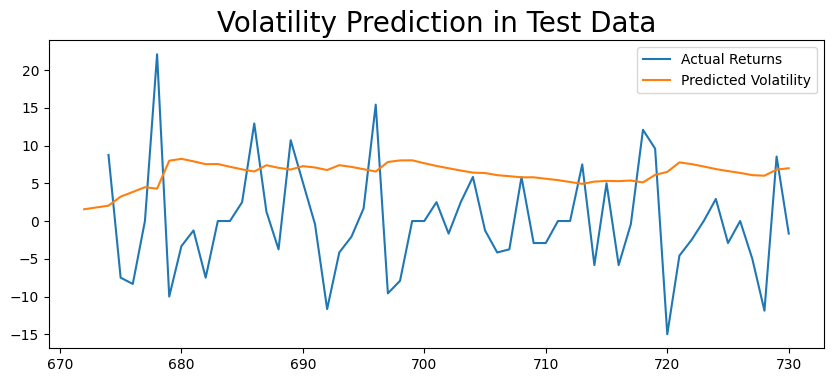

In [97]:
plt.figure(figsize=(10,4))
true, = plt.plot(test_data['TMA_Daily_Diff'])
preds, = plt.plot(condvar_test)
plt.title('Volatility Prediction in Test Data', fontsize=20)
plt.legend(['Actual Returns', 'Predicted Volatility'], fontsize=10)

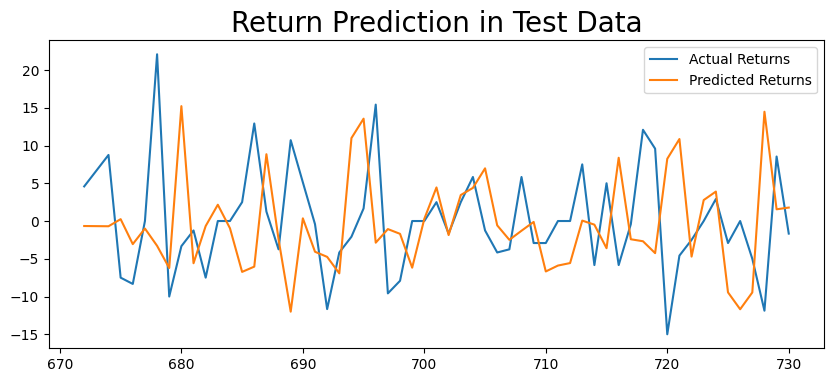

In [98]:
plt.figure(figsize=(10,4))
true, = plt.plot(data_diff[-58:])
preds, = plt.plot(predicted_test)
plt.title('Return Prediction in Test Data', fontsize=20)
plt.legend(['Actual Returns', 'Predicted Returns'], fontsize=10)

In [99]:
predicted_test.to_excel("predicted_test.xlsx", index=False)

## Peramalan

Peramalan (forecasting) terhadap data dilakukan hingga 60 periode ke depan.


In [100]:
from datetime import datetime, timedelta

data_diff.index = pd.to_datetime(data_diff.index)

pred = result_garch11_diff.forecast(horizon=60)
future_dates = [data_diff.index[-1] + timedelta(days=i) for i in range(1,61)]
condvar_forecast = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=future_dates)

Text(0.5, 1.0, 'Volatility Prediction - Next 60 Days')

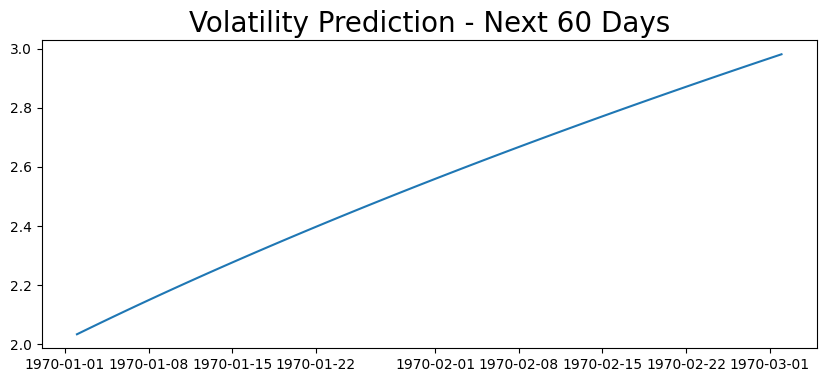

In [101]:
plt.figure(figsize=(10,4))
plt.plot(condvar_forecast)
plt.title('Volatility Prediction - Next 60 Days', fontsize=20)

In [102]:
np.random.seed(31)
epsilon_forecast = np.random.normal(0, 1, 60)

In [103]:
predicted_forecast = condvar_forecast * epsilon_forecast - 0.0159
predicted_forecast

,0
1970-01-02 00:00:00.000000730,-0.859597
1970-01-03 00:00:00.000000730,-0.700596
1970-01-04 00:00:00.000000730,0.152233
1970-01-05 00:00:00.000000730,-1.671254
1970-01-06 00:00:00.000000730,-0.477538
1970-01-07 00:00:00.000000730,-1.642084
1970-01-08 00:00:00.000000730,-1.686354
1970-01-09 00:00:00.000000730,3.993824
1970-01-10 00:00:00.000000730,-1.558795
1970-01-11 00:00:00.000000730,-0.205619


Text(0.5, 1.0, 'Return Forecast - Next 60 Days')

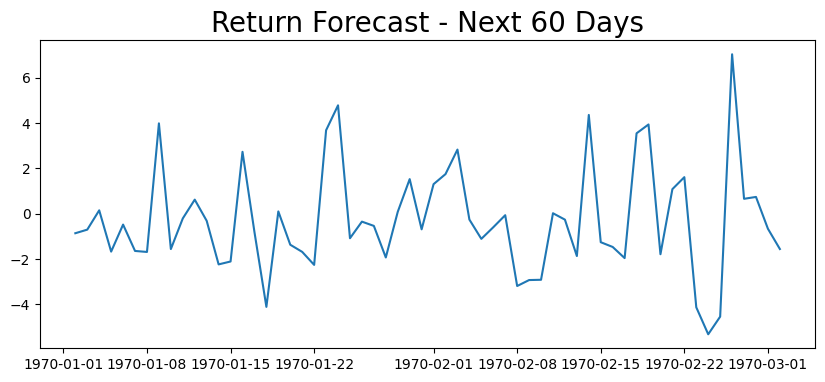

In [104]:
plt.figure(figsize=(10,4))
plt.plot(predicted_forecast)
plt.title('Return Forecast - Next 60 Days', fontsize=20)

In [105]:
predicted_forecast.to_excel("forecasted_return_60.xlsx", index=False)